In [13]:
import numpy as np # numerical python
import pandas as pd # excel / csv load
import tensorflow as tf # built the model
from matplotlib import pyplot as plt # data visualization   
from sklearn.model_selection import train_test_split # dataset split

In [14]:
def create_ts_dataset(
                        data_path='data/Consumption.csv',
                        hh_dict = {
                                'Single-Family': 0,
                                'Large Family': 1,
                                'Apartment': 2
                                },
                        sel_window = 180,
                        pred_window = 30
                        ):
        df = pd.read_csv(data_path)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Household_Type'] = df['Household_Type'].map(hh_dict)
        del df['Monthly_Bill_LKR'], df['Timestamp']

        X, Y = [], []
        for i in range(len(df) - sel_window - pred_window):
                data = df.iloc[i:i+sel_window]
                target = df.iloc[i+sel_window:i+sel_window+pred_window]['Electricity_Consumption_kWh']
                X.append(data.values)
                Y.append(target.values)

        X = np.array(X)
        Y = np.array(Y)

        return X, Y

In [15]:
X, Y = create_ts_dataset()
print(f"X shape: {X.shape}\nY shape: {Y.shape}")

X shape: (2347, 180, 4)
Y shape: (2347, 30)


In [16]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                X, Y, 
                                                test_size=0.15, 
                                                random_state=42
                                                )

In [17]:
lstm_model = tf.keras.models.Sequential([
                                        tf.keras.layers.LSTM(
                                                            128, 
                                                            input_shape=(
                                                                        X.shape[1], 
                                                                        X.shape[2]
                                                                        ), 
                                                            return_sequences=True
                                                            ),
                                        tf.keras.layers.LSTM(
                                                            64, 
                                                            return_sequences=True
                                                            ),
                                        tf.keras.layers.LSTM(32),
                                        tf.keras.layers.Dense(Y.shape[1])
                                        ])
lstm_model.compile(
                    optimizer='adam', 
                    metrics=['mae'],
                    loss='mse'
                    )
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 180, 128)          68096     
                                                                 
 lstm_4 (LSTM)               (None, 180, 64)           49408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 30)                990       
                                                                 
Total params: 130,910
Trainable params: 130,910
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = lstm_model.fit(
                        Xtrain, Ytrain, 
                        epochs=100, batch_size=64 , 
                        validation_data=(Xtest, Ytest),
                        callbacks=[
                                    tf.keras.callbacks.EarlyStopping(
                                                                      patience=50, 
                                                                      restore_best_weights=True
                                                                      )
                                    ]
                        )

Epoch 1/100
32/32 [==============================] - 15s 370ms/step - loss: 32.3702 - mae: 5.2948 - val_loss: 24.6901 - val_mae: 4.4952
Epoch 2/100
32/32 [==============================] - 11s 348ms/step - loss: 19.8405 - mae: 3.9124 - val_loss: 15.2415 - val_mae: 3.3243
Epoch 3/100
32/32 [==============================] - 13s 413ms/step - loss: 12.4741 - mae: 2.9200 - val_loss: 9.7679 - val_mae: 2.5195
Epoch 4/100
32/32 [==============================] - 13s 400ms/step - loss: 8.2416 - mae: 2.2779 - val_loss: 6.7700 - val_mae: 2.0562
Epoch 5/100
32/32 [==============================] - 13s 408ms/step - loss: 5.9754 - mae: 1.9293 - val_loss: 5.1945 - val_mae: 1.8214
Epoch 6/100
32/32 [==============================] - 14s 432ms/step - loss: 4.8086 - mae: 1.7580 - val_loss: 4.4059 - val_mae: 1.7080
Epoch 7/100
32/32 [==============================] - 13s 410ms/step - loss: 4.2357 - mae: 1.6806 - val_loss: 4.0284 - val_mae: 1.6570
Epoch 8/100
32/32 [==============================] - 14s 

In [19]:
lstm_model.save('artifacts/energy_consumption.h5')

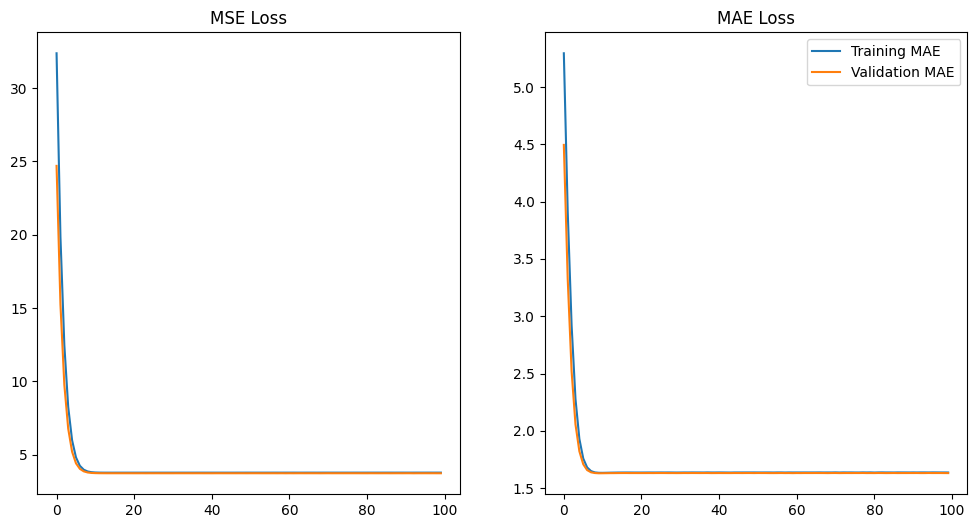

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MSE Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Loss')

plt.legend()
plt.show()

### inference

In [21]:
import pprint
import numpy as np
import pandas as pd
import tensorflow as tf

In [22]:
model_consumption = tf.keras.models.load_model('artifacts/energy_consumption.h5')
model_consumption.compile(
                        optimizer='adam', 
                        metrics=['mae'],
                        loss='mse'
                        )

In [23]:
def calculate_electricity_bill(daily_consumption):
    monthly_consumption = daily_consumption.sum()
    
    consumption_charge = 0
    fixed_charge = 0

    if monthly_consumption <= 60:
        if monthly_consumption <= 30:
            consumption_charge = monthly_consumption * 6.00
            fixed_charge = 100.00
        else:
            consumption_charge = 30 * 6.00 + (monthly_consumption - 30) * 9.00
            fixed_charge = 250.00
    else:
        if monthly_consumption <= 90:
            consumption_charge = 60 * 15.00 + (monthly_consumption - 60) * 18.00
            fixed_charge = 400.00
        elif monthly_consumption <= 120:
            consumption_charge = 60 * 15.00 + 30 * 18.00 + (monthly_consumption - 90) * 30.00
            fixed_charge = 1000.00
        elif monthly_consumption <= 180:
            consumption_charge = 60 * 15.00 + 30 * 18.00 + 30 * 30.00 + (monthly_consumption - 120) * 42.00
            fixed_charge = 1500.00
        else:
            consumption_charge = (60 * 15.00 + 30 * 18.00 + 30 * 30.00 +
                                  60 * 42.00 + (monthly_consumption - 180) * 65.00)
            fixed_charge = 2000.00

    total_charge = consumption_charge + fixed_charge
    ssc_levy = (total_charge / 97.5) * 2.5

    final_bill = total_charge + ssc_levy

    return {
        "Monthly Consumption (kWh)": monthly_consumption,
        "Consumption Charge (Rs)": consumption_charge,
        "Fixed Charge (Rs)": fixed_charge,
        "S.S.C Levy (Rs)": ssc_levy,
        "Final Bill (Rs)": final_bill
        }

def inference_consumption(
                        data_path='data/Consumption.csv',
                        hh_dict = {
                                'Single-Family': 0,
                                'Large Family': 1,
                                'Apartment': 2
                                },
                        sel_window = 180
                        ):
        df = pd.read_csv(data_path)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Household_Type'] = df['Household_Type'].map(hh_dict)
        del df['Monthly_Bill_LKR'], df['Timestamp']

        data = df.iloc[-sel_window:]
        data = np.expand_dims(data.values, axis=0)
        prediction = model_consumption.predict(data)
        consumption_for_month = prediction.squeeze().astype(float)
        bill_data = calculate_electricity_bill(consumption_for_month)
        return bill_data

In [24]:
bill_data = inference_consumption()
pprint.pprint(bill_data)

1/1 [==============================] - 1s 1s/step
{'Consumption Charge (Rs)': 4980.8304262161255,
 'Final Bill (Rs)': 7159.826078170385,
 'Fixed Charge (Rs)': 2000.0,
 'Monthly Consumption (kWh)': 181.85892963409424,
 'S.S.C Levy (Rs)': 178.99565195425964}
